In [ ]:
"""
Gaussian-Bernoulli RBM 

DATA_TYPE  =1 Olivetti faces = 2 CIFAR10 images = 3 Art images (given in npy arrays)

VanGogh64x64.npy
StillLife64x64.npy
Modigliani_paintings.npy
Abstractblue.npy

#image values are already normalized in [0 1]

libraries: 

!pip install opencv-python tensorflow keras numpy scikit-learn 
"""


In [ ]:
!pip install opencv-python tensorflow keras numpy scikit-learn

In [ ]:
"""

MAIN RBM CODE

choose data ( line 80 of the next cell) 

DATA_TYPE  # =1 Olivetti faces = 2 CIFAR10 images  = 3 Art 


if DATA_TYPE =3 choose numpy array to load  ( line 113 of the next cell) 

    #facesRGB = np.load("VanGogh64x64.npy" # data already normalized in [0 1]
    facesRGB = np.load("StillLife64x64.npy") # data already normalized in [0 1]
    #facesRGB = np.load("Modigliani_paintings.npy") # data already normalized in [0 1]
    
"""

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from scipy.special import expit
from sklearn.datasets import fetch_olivetti_faces
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from scipy.special import expit



# Define stable sigmoid function
#def sigmoid(x):
#    return 1 / (1 + np.exp(-x))
def sigmoid(x):
    return expit(x)
    
# Initialize RBM parameters
class GaussianBernoulliRBM:
    def __init__(self, visible_units, hidden_units, learning_rate, sig):
        self.v_units = visible_units
        self.h_units = hidden_units
        self.lr = learning_rate
        self.sigma = sig
        
        # Initialize weights and biases
        self.W = np.random.randn(self.v_units, self.h_units) * 0.01  # Small random values
        self.b_v = np.zeros(self.v_units)  # Visible biases
        self.b_h = np.zeros(self.h_units)  # Hidden biases

    # Forward pass: Sample hidden states given visible states
    def sample_hidden(self, v):
        h_mean = sigmoid( np.dot(v, self.W)/( (self.sigma) **2 ) + self.b_h )
        #h_sample = np.random.binomial(1, h_mean)  # Bernoulli sample
        h_sample = (np.random.uniform(size=h_mean.shape) < h_mean).astype(np.float32)
        return h_mean, h_sample

    # Backward pass: Sample visible states given hidden states
    def sample_visible(self, h):
        v_mean = np.dot(h, self.W.T) + self.b_v  # Gaussian visible layer
        v_sample = v_mean + self.sigma * np.random.randn(*v_mean.shape)  # Add Gaussian noise
        return v_mean, v_sample

    # Train RBM with Contrastive Divergence (CD-1)
    def train(self, data, epochs, batch_size):
        num_samples = data.shape[0]

        for epoch in range(epochs):
            np.random.shuffle(data)  # Shuffle data each epoch

            for i in range(0, num_samples, batch_size):
                v_0 = data[i:i+batch_size]  # Mini-batch

                # Positive phase
                h_0_mean, h_0_sample = self.sample_hidden(v_0)

                # Negative phase (Reconstruct visible layer)
                v_k_mean, v_k_sample = self.sample_visible(h_0_sample)
                h_k_mean, _ = self.sample_hidden(v_k_sample)

                # Update weights and biases
                self.W += self.lr * (np.dot(v_0.T, h_0_mean) - np.dot(v_k_sample.T, h_k_mean)) / batch_size
                self.b_v += self.lr * np.mean(v_0 - v_k_sample, axis=0)
                self.b_h += self.lr * np.mean(h_0_mean - h_k_mean, axis=0)

            print(f"\rEpoch {epoch+1}/{epochs} completed.", end=" ")

    # Generate samples from the trained RBM
    def generate_samples(self, num_samples, steps):
        v = np.random.randn(num_samples, self.v_units)  # Random initialization

        for _ in range(steps):  # Gibbs Sampling
            h_mean, h_sample = self.sample_hidden(v)
            v_mean, v = self.sample_visible(h_sample)

        return v_mean, h_mean # Return final generated visible samples and hidden variables 

# main 

DATA_TYPE = 2 # =1 Olivetti faces = 2 CIFAR10 images  = 3 Art 
if DATA_TYPE == 1: 
    # Load and preprocess Face data
    data = fetch_olivetti_faces(shuffle=True)
    faces = data.images  # 400 samples of 64x64 grayscale face images
    img_size=64 
    num_samples = 400  
    hidden_size=64  # number of hidden variables 


if DATA_TYPE == 2:
    #CIFAR-10 dataset contains 6000 images per class  (5000 training, 1000 testing)
    #(5000 for training, 1000 for testing).
    #Each CIFAR-10 image has a size of 32 × 32 × 3 (height × width × color channels).
    #there are 10 classes: #0=Airplane, 1=Automobile, 2=Bird, 3=Cat, 4=Deer, 5=Dog, 6=Frog, 7=Horse, 8=Ship, 9=Truck
    
    # Load CIFAR-10 dataset
    (x_train_RGB, y_train), (x_test, y_test) = cifar10.load_data()
    x_train = x_train_RGB[:, :, :, 2]/255  # get only blue channel
    #for conversion to gray scale
    #x_train = 0.2989 * x_train[:, :, :, 0] + 0.5870 * x_train[:, :, :, 1] + 0.1140 * x_train[:, :, :, 2]
    
    #0=Airplane, 1=Automobile, 2=Bird, 3=Cat, 4=Deer, 5=Dog, 6=Frog, 7=Horse, 8=Ship, 9=Truck
    # Choose a class to train on (e.g., "airplane" = class 0)
    chosen_class = 8
    faces= x_train[y_train.flatten() == chosen_class]
    img_size=32 
    num_samples = 5000 
    hidden_size=64  # number of hidden variables 

if DATA_TYPE == 3: 
    #(189, 64, 64, 3)
    #facesRGB = np.load("VanGogh64x64.npy" # data already normalized in [0 1]
    facesRGB = np.load("StillLife64x64.npy") # data already normalized in [0 1]
    #facesRGB = np.load("Modigliani_paintings.npy") # data already normalized in [0 1]
    faces = facesRGB[:,:,:,2] # get only blue channel
    num_samples, img_size, _ = faces.shape
    hidden_size=32 # number of hidden variables 

faces_flat = faces.reshape(num_samples, -1) #Array 400 x 64^2

# Normalize images to [-1,1] for Gaussian-Bernoulli RBM
faces_flat = (faces_flat - 0.5) * 2  

fig, axes = plt.subplots(1, 8, figsize=(10, 3))
for i, ax in enumerate(axes):
    img = faces[i].reshape(img_size, img_size)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img)
    ax.axis("off")

if DATA_TYPE == 1: 
    plt.suptitle("Face Samples")

if DATA_TYPE == 2: 
    plt.suptitle("CIFAR10 Samples")

if DATA_TYPE == 3: 
    plt.suptitle("Art Samples")

plt.show()


# Train RBM on CBL Faces
rbm = GaussianBernoulliRBM(visible_units=img_size**2, hidden_units=hidden_size, learning_rate=0.005, sig=0.01)
rbm.train(faces_flat, epochs=10000, batch_size=16)

# Generate and plot new face samples
generated_faces, generated_hidden_var= rbm.generate_samples(num_samples=36, steps=1000)

fig, axes = plt.subplots(6, 6, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_faces[i].reshape(img_size, img_size)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img, cmap='gray')
    ax.axis("off")

if DATA_TYPE == 1: 
    plt.suptitle("Generated Face Samples")

if DATA_TYPE == 2: 
    plt.suptitle("CIFAR10 Samples")

if DATA_TYPE == 3: 
    plt.suptitle("Art Samples")
    
plt.show()

hidden_n = int(np.sqrt(hidden_size)) 
# Plot weight columns as images (Visualizing hidden features)
fig, axes = plt.subplots(hidden_n, hidden_n, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    if i < rbm.h_units:
        img = rbm.W[:, i].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        ax.imshow(img, cmap='gray')
    ax.axis("off")
plt.suptitle("Weight Columns as Images (Hidden Features)")
plt.show()


ModuleNotFoundError: No module named 'tensorflow.keras'

In [2]:
"""
Generate and plot new samples
"""

'\nGenerate and plot new samples\n'

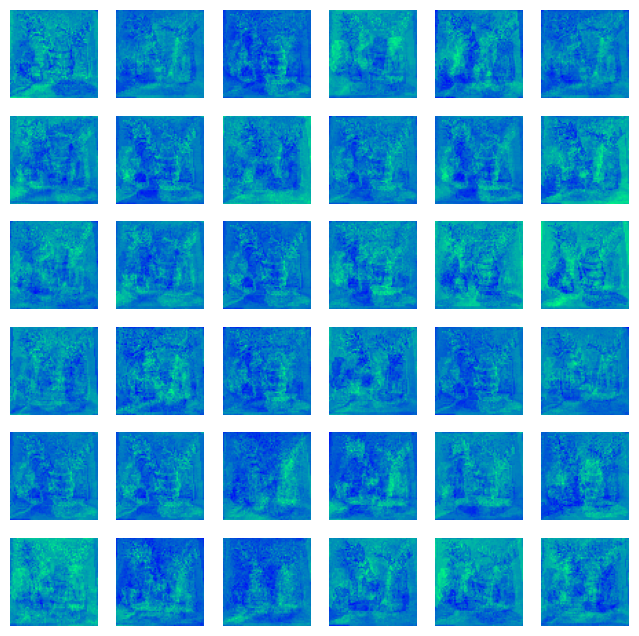

In [2]:
# Generate and plot new samples
generated_faces, generated_hidden_var= rbm.generate_samples(num_samples=36, steps=1000)

fig, axes = plt.subplots(6, 6, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    img = generated_faces[i].reshape(img_size, img_size)
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
    ax.imshow(img, cmap='winter')
    ax.axis("off")

In [ ]:
"""
PLOT PROBABILITY DENSITY FUNCTION OF THE DATA
"""

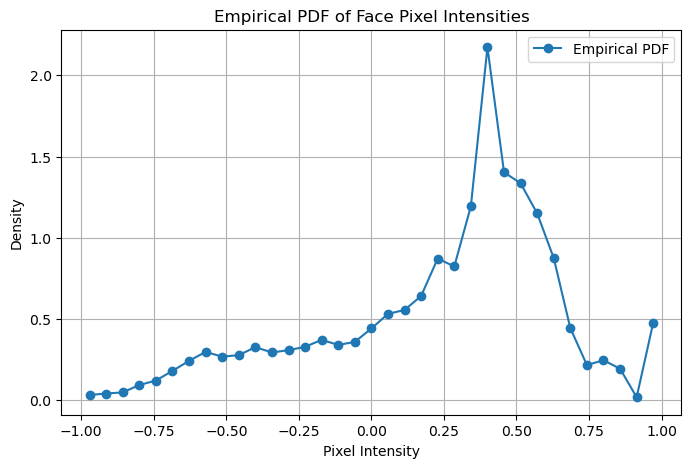

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Assume x_train is (400, 32, 32)
x1= faces_flat.reshape(-1)  # Flatten all pixels into 1D

# Compute histogram (PDF estimation)
hist, bins = np.histogram(x1, bins=35, density=True)

# Compute bin centers
bin_centers = (bins[:-1] + bins[1:]) / 2

# Plot empirical PDF
plt.figure(figsize=(8, 5))
plt.plot(bin_centers, hist, linestyle='-', marker='o', label="Empirical PDF")
plt.xlabel("Pixel Intensity")
plt.ylabel("Density")
plt.title("Empirical PDF of Face Pixel Intensities")
plt.grid(True)
plt.legend()
plt.show()



In [ ]:
"""
Plot weight columns as images (Visualizing hidden features)
"""

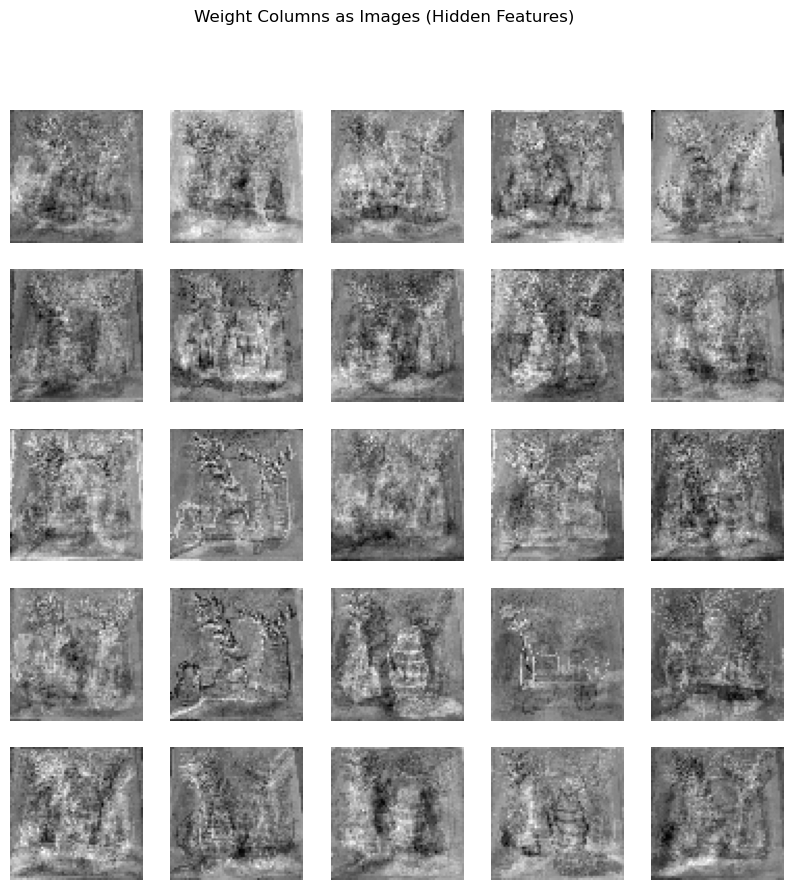

In [4]:

# Plot weight columns as images (Visualizing hidden features)
fig, axes = plt.subplots(hidden_n, hidden_n, figsize=(10, 10))
for i, ax in enumerate(axes.flat):
    if i < rbm.h_units:
        img = rbm.W[:, i].reshape(img_size, img_size)
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for visualization
        ax.imshow(img, cmap='gray')
    ax.axis("off")
plt.suptitle("Weight Columns as Images (Hidden Features)")
plt.show()
